In [1]:
import numpy as np
import torch
import matplotlib.pyplot as pl
import seaborn as sns
import ot
import ot.plot

In [2]:
import sys
sys.path.append('../code/')
from generate_data import make_data_1d
from sinkhorn_iterates import sinkhorn
from sinkhorn_iterates_logdomain import logsinkhorn
from linear_solver import UOT_W, UOT_KL

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cpu


In [4]:
def make_data_1d(expe,n_samples,device='cpu'):        
    if expe=="noise":
        xs=np.random.normal(-10, .7, 2*n_samples)
        xt=np.concatenate((np.random.normal(0, .7, n_samples),np.random.normal(10, .7, n_samples)))  

    
    X = torch.from_numpy(xs).to(device)
    Y = torch.from_numpy(xt).to(device)
    X=X.float()
    Y=Y.float()
    return X,Y

# Noise

100 100


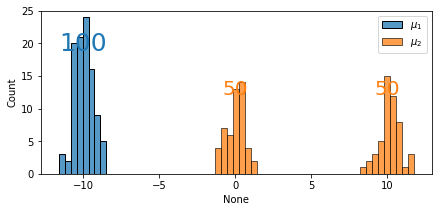

In [5]:
np.random.seed(1)
X,Y=make_data_1d("noise",50)
n,m=X.shape[0],Y.shape[0]
a,b=torch.ones((n,)),torch.ones((m,))
print(n,m)
C=ot.dist(X[:,None],Y[:,None])

kde=False
pl.figure(figsize=(7,3))
sns.histplot(x=X, kde=kde,label="$\mu_1$",weights=a,binwidth=.4,kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y, kde=kde,label="$\mu_2$",weights=b,binwidth=.4,kde_kws=dict(bw_adjust=.5),stat="count")
pl.text(-10,20,100 ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
pl.text(0,13, 50,c="C1",alpha=1,ha="center",va="center",fontsize = 20)
pl.text(10, 13, 50,c="C1",alpha=1,ha="center",va="center",fontsize = 20)
pl.ylim(0,25)
pl.legend()

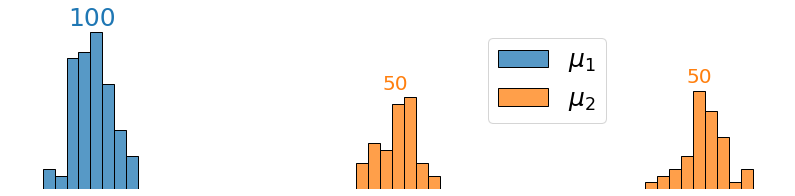

In [6]:
kde=False
pl.figure(figsize=(14,3))
sns.histplot(x=X, kde=kde,label="$\mu_1$",weights=a,binwidth=.4,kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y, kde=kde,label="$\mu_2$",weights=b,binwidth=.4,kde_kws=dict(bw_adjust=.5),stat="count")
pl.text(-10,26,100 ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
pl.text(0,16, 50,c="C1",alpha=1,ha="center",va="center",fontsize = 20)
pl.text(10, 17, 50,c="C1",alpha=1,ha="center",va="center",fontsize = 20)
pl.ylim(0,25)
pl.legend(bbox_to_anchor=(.6,1), prop={'size': 25})
pl.axis("off")
pl.savefig("../Figures/empirical_toy_clean.pdf",bbox_inches='tight')

In [7]:
lam=[60,150,400]
#print(lam)
P_KL=[]
pi1_KL=[]
pi2_KL=[]
for l in lam:
    P=UOT_KL(a,b,C,lam=l,solver="CLARABEL")
    P=torch.tensor(P).float()
    print(torch.sum(P))
    P_KL+=[P]
    pi1_KL+=[P@torch.ones(m)]
    pi2_KL+=[(P.T)@torch.ones(n)]    

tensor(31.4507)


/home/gui/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


tensor(54.5153)
tensor(76.0340)


In [8]:
wKL1=[]
wKL2=[]
wKL3=[]
for i in range(len(lam)):
    print(torch.sum(pi1_KL[i]),torch.sum(pi2_KL[i][:50]),torch.sum(pi2_KL[i][50:]))
    wKL1+=[np.round(torch.sum(pi1_KL[i]).numpy(),2)]
    wKL2+=[np.round(torch.sum(pi2_KL[i][:50]).numpy(),2)]
    wKL3+=[np.round(torch.sum(pi2_KL[i][50:]).numpy(),2)]

tensor(31.4507) tensor(31.1156) tensor(0.3351)
tensor(54.5153) tensor(47.5336) tensor(6.9818)
tensor(76.0340) tensor(51.5389) tensor(24.4951)


/tmp/ipykernel_10954/3014865683.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


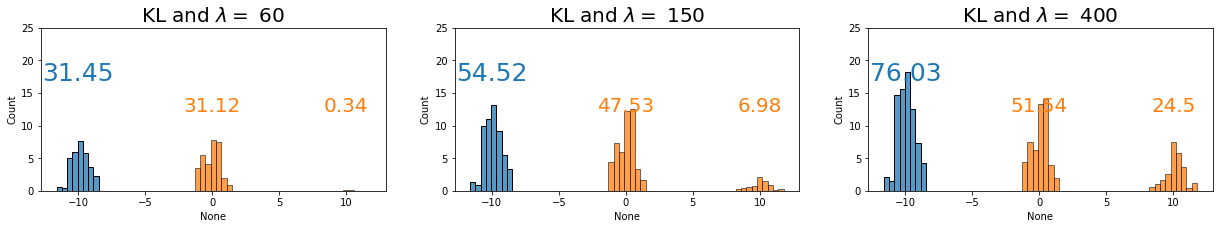

In [9]:
kde=False
fig = pl.figure(figsize=(21,3))
grid = pl.GridSpec(1, len(lam), wspace=.2,hspace=0.5)
for i in range(len(lam)):
    pl.subplot(grid[0, i])
    sns.histplot(x=X, kde=kde,label="mu",binwidth=.4,weights=pi1_KL[i],kde_kws=dict(bw_adjust=.5))
    sns.histplot(x=Y, kde=kde,label="nu",binwidth=.4,weights=pi2_KL[i],kde_kws=dict(bw_adjust=.5))
    pl.text(-10,18,wKL1[i] ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
    pl.text(0,13, wKL2[i],c="C1",alpha=1,ha="center",va="center",fontsize = 20)
    pl.text(10, 13, wKL3[i],c="C1",alpha=1,ha="center",va="center",fontsize = 20)
    pl.ylim(0,25)
    pl.title("KL and $\lambda =$ %i"%lam[i],size=20)
pl.tight_layout()
pl.savefig("../Figures/empirical_toy_KL.pdf",bbox_inches='tight')

/tmp/ipykernel_10954/3608970350.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()
/tmp/ipykernel_10954/3608970350.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


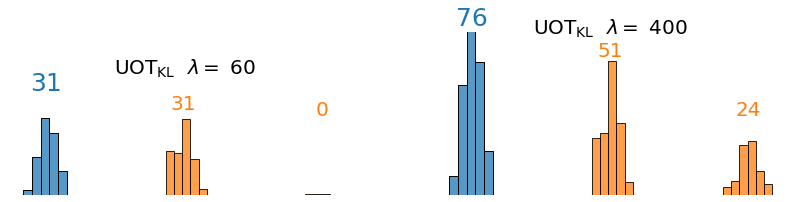

In [10]:
kde=False
fig = pl.figure(figsize=(14,3))
grid = pl.GridSpec(1, 2, wspace=.2,hspace=0.5)

i=0
pl.subplot(grid[0, 0])
sns.histplot(x=X, kde=kde,label="mu",binwidth=.6,weights=pi1_KL[i],kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y, kde=kde,label="nu",binwidth=.6,weights=pi2_KL[i],kde_kws=dict(bw_adjust=.5))
pl.text(-10,17,int(wKL1[i]) ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
pl.text(0,14, int(wKL2[i]),c="C1",alpha=1,ha="center",va="center",fontsize = 20)
pl.text(10, 13, int(wKL3[i]),c="C1",alpha=1,ha="center",va="center",fontsize = 20)
pl.ylim(0,25)
pl.title("$\mathrm{UOT}_\mathrm{KL}$  $\lambda =$ %i"%lam[i],size=20,x=.5,y=.7)
pl.axis("off")
pl.tight_layout()

i=2
pl.subplot(grid[0, 1])
sns.histplot(x=X, kde=kde,label="mu",binwidth=.6,weights=pi1_KL[i],kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y, kde=kde,label="nu",binwidth=.6,weights=pi2_KL[i],kde_kws=dict(bw_adjust=.5))
pl.text(-10,27,int(wKL1[i]) ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
pl.text(0,22, int(wKL2[i]),c="C1",alpha=1,ha="center",va="center",fontsize = 20)
pl.text(10, 13, int(wKL3[i]),c="C1",alpha=1,ha="center",va="center",fontsize = 20)
pl.ylim(0,25)
pl.title("$\mathrm{UOT}_\mathrm{KL}$  $\lambda =$ %i"%lam[i],size=20,x=.5,y=.95)

pl.axis("off")
pl.tight_layout()
pl.savefig("../Figures/empirical_toy_KL_clean.pdf",bbox_inches='tight')

In [12]:
lam=[1,4,5,7,10,20]
Cx,Cy=ot.dist(X[:,None],X[:,None]),ot.dist(Y[:,None],Y[:,None])
P_W=[]
pi1_W=[]
pi2_W=[]
for l in lam:
    P=UOT_W(a,b,C,lam=l,Cx=Cx,Cy=Cy,solver="CLARABEL")
    P=torch.tensor(P).float()
    print(torch.sum(P))
    P_W+=[P]
    pi1_W+=[abs(P)@torch.ones(m)]
    pi2_W+=[abs(P.T)@torch.ones(n)]    

tensor(100.0000)
tensor(100.)
tensor(100.)
tensor(100.0000)
tensor(100.0000)
tensor(100.)


In [13]:
wW1=[]
wW2=[]
wW3=[]
for i in range(len(lam)):
    print(torch.sum(pi1_W[i]),torch.sum(pi2_W[i][:50]),torch.sum(pi2_W[i][50:]))
    wW1+=[np.round(torch.sum(pi1_W[i]).numpy(),2)]
    wW2+=[np.round(torch.sum(pi2_W[i][:50]).numpy(),2)]
    wW3+=[np.round(torch.sum(pi2_W[i][50:]).numpy(),2)]

tensor(100.) tensor(100.0000) tensor(6.0402e-07)
tensor(100.) tensor(50.) tensor(50.)
tensor(100.) tensor(50.) tensor(50.)
tensor(100.0000) tensor(50.0000) tensor(50.)
tensor(100.0000) tensor(50.0000) tensor(50.)
tensor(100.0000) tensor(50.) tensor(50.)


/tmp/ipykernel_10954/3698169744.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


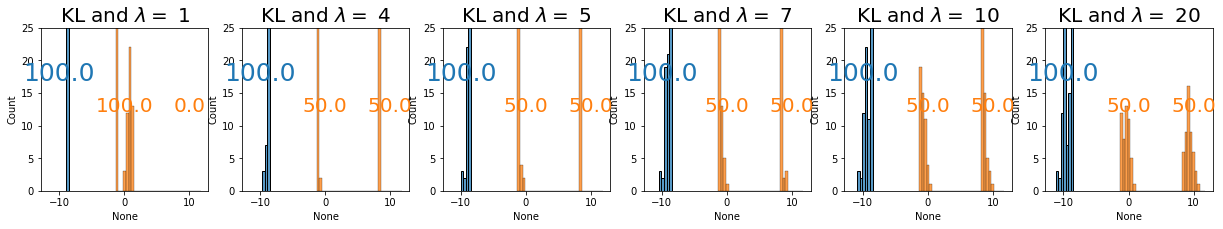

In [15]:
kde=False
fig = pl.figure(figsize=(21,3))
grid = pl.GridSpec(1, len(lam), wspace=.2,hspace=0.5)
for i in range(len(lam)):
    pl.subplot(grid[0, i])
    sns.histplot(x=X, kde=kde,label="mu",binwidth=.4,weights=pi1_W[i],kde_kws=dict(bw_adjust=.5))
    sns.histplot(x=Y, kde=kde,label="nu",binwidth=.4,weights=pi2_W[i],kde_kws=dict(bw_adjust=.5))
    pl.text(-10,18,wW1[i] ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
    pl.text(0,13, wW2[i],c="C1",alpha=1,ha="center",va="center",fontsize = 20)
    pl.text(10, 13, wW3[i],c="C1",alpha=1,ha="center",va="center",fontsize = 20)
    pl.ylim(0,25)
    pl.title("KL and $\lambda =$ %i"%lam[i],size=20)
pl.tight_layout()
pl.savefig("../Figures/empirical_toy_KL.pdf",bbox_inches='tight')

/tmp/ipykernel_10954/1180103429.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


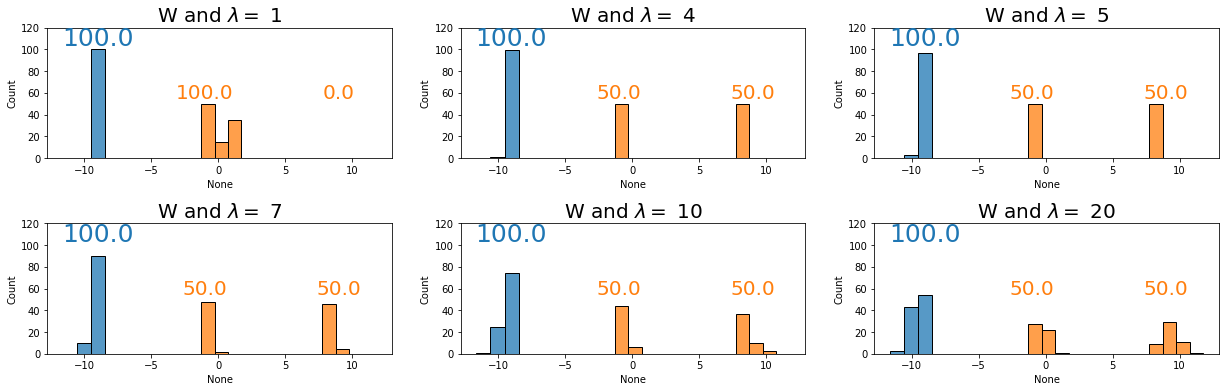

In [16]:
kde=False
fig = pl.figure(figsize=(21,3*(len(lam)//3)))
grid = pl.GridSpec(2, 3, wspace=.2,hspace=0.5)
for i in range(len(lam)):
    pl.subplot(grid[i//3, i%3])
    sns.histplot(x=X, kde=kde,label="mu",binwidth=1,weights=pi1_W[i],kde_kws=dict(bw_adjust=2))
    sns.histplot(x=Y, kde=kde,label="nu",binwidth=1,weights=pi2_W[i],kde_kws=dict(bw_adjust=2))
    pl.text(-9,110,wW1[i] ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
    pl.text(-1,60, wW2[i],c="C1",alpha=1,ha="center",va="center",fontsize = 20)
    pl.text(9, 60, wW3[i],c="C1",alpha=1,ha="center",va="center",fontsize = 20)
    pl.ylim(0,120)
    pl.title("W and $\lambda =$ %i"%lam[i],size=20)
pl.tight_layout()
pl.savefig("../Figures/empirical_toy_W.pdf",bbox_inches='tight')

/tmp/ipykernel_10954/799770266.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


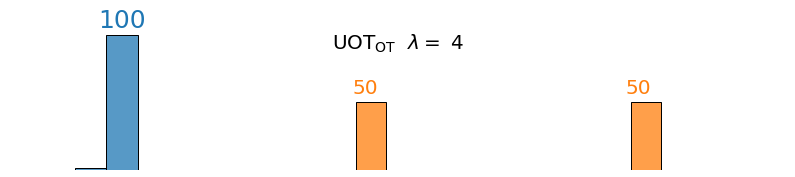

In [17]:
kde=False
fig = pl.figure(figsize=(14,3))
grid = pl.GridSpec(1, 1, wspace=.2,hspace=0.5)

i=1
pl.subplot(grid[0, 0])
sns.histplot(x=X, kde=kde,label="mu",binwidth=1,weights=pi1_W[i],kde_kws=dict(bw_adjust=2))
sns.histplot(x=Y, kde=kde,label="nu",binwidth=1,weights=pi2_W[i],kde_kws=dict(bw_adjust=2))
pl.text(-9,110,int(wW1[i]) ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
pl.text(-1,60, int(wW2[i]),c="C1",alpha=1,ha="center",va="center",fontsize = 20)
pl.text(8, 60, int(wW3[i]),c="C1",alpha=1,ha="center",va="center",fontsize = 20)
pl.ylim(0,120)
pl.title("$\mathrm{UOT}_\mathrm{OT}$  $\lambda =$ %i"%lam[i],size=20,y=.7,x=.5)
pl.axis("off")
pl.tight_layout()
pl.savefig("../Figures/empirical_toy_W_clean.pdf",bbox_inches='tight')